# Introdução:

A presente análise tem por objetivo preparar uma pesquisa de mercado alimentício de Los Angeles para respaldar a apresentação aos futuros investidores do projeto da Cafeteria Café Robo em L.A.

Iremos analisar no decorrer deste trabalho os seguintes tópicos:


* Investigar as proporções de vários tipos de estabelecimentos.
* Investigar as proporções de estabelecimentos de rede e não.
* Qual tipo de estabelecimento é típico para redes?
* O que caracteriza redes: muitos estabelecimentos com um pequeno número de assentos ou poucos estabelecimentos com muitos assentos?
* Determinar o número médio de assentos para cada tipo de restaurante. Em média, qual tipo de restaurante tem o maior número de assentos?
* Coloque os dados dos nomes das ruas da coluna address em uma coluna separada.
* Construir um gráfico de dez ruas com o maior número de restaurantes.
* Encontrar o número de ruas que têm apenas um restaurante.
* Para as ruas com muitos restaurantes, olhar para a distribuição de número de assentos.

Com o fim de obter uma recomendação baseada em dados sobre o tipo mais apropriado, o modelo e a quantidade de assentos que se deve ter no empreendimento. Talvez com a possibilidade de desenvolver uma rede.

# Carregando bibliotecas

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re
import usaddress


# Importando Dataset

In [69]:

try:
    df = pd.read_csv('rest_data_us.csv')

except:
    df= pd.read_csv(r'/datasets/rest_data_us.csv')

# Informações do Dataset

Descrição de dados:

* Tabela rest_data;
* object_name — nome de estabelecimento
* chain - estabelecimento de rede (TRUE/FALSE)
* object_type — tipo de estabelecimento
* address — endereço
* number — número de assentos

# Funções usadas

In [71]:


def addr_parse(x):
    parsed_address = usaddress.parse(x)
    street_name = ""
    for part in parsed_address:
        if part[1] == "StreetName" or part[1] == "StreetNamePostType":
            street_name += part[0] + " "
    return street_name

# 1. Visualisando o Dataset

In [72]:
display(df.head())

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


In [73]:

print('='*86)
print(df.info())
print('='*86)
print(df.describe())
print('='*86)
print('Valores duplicados:', df.duplicated().sum())
print('='*86)
print('Valores nulos:\n', 
      df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB
None
                 id       number
count   9651.000000  9651.000000
mean   16611.000000    43.695161
std     2786.148058    47.622874
min    11786.000000     1.000000
25%    14198.500000    14.000000
50%    16611.000000    27.000000
75%    19023.500000    46.000000
max    21436.000000   229.000000
Valores duplicados: 0
Valores nulos:
 id             0
object_name    0
address        0
chain          3
object_type    0
number         0
dtype: int64


In [74]:
df[df['chain'].isna()]

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35


Os três valores nulos encontrados no data set, foram na coluna chain. Logo, é de fácil resolução, já que os estabelecimentos:

* TAQUERIA LOS 3 CARNALES;
* JAMMIN JIMMY'S PIZZA; 
* THE LEXINGTON THEATER.

Não são estabelecimentos de rede, o valor a ser atribuido na coluna será False.

In [75]:
df[df['object_name'] == "JAMMIN JIMMY'S PIZZA"]

,id,object_name,address,chain,object_type,number
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1


In [76]:
# Preenchendo valor faltante 
df['chain'] = df['chain'].fillna(value=False)


In [77]:
df[(df['object_name'] == "TAQUERIA LOS 3 CARNALES")| (df['object_name'] == "JAMMIN JIMMY'S PIZZA")| (df['object_name'] == "THE LEXINGTON THEATER")]

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,False,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,False,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,False,Restaurant,35


Foi observado que há valores nos nomes dos estabelecimentos que se repetem escritos de forma diferente. Que será tratado logo abaixo.

In [78]:
list_rests = ["SUBWAY", "THE COFFEE BEAN & TEA LEAF", "DOMINO'S PIZZA","KFC", "KENTUCKY FRIED CHICKEN", "WABA GRILL", "MCDONALD'S", "TRIMANA", "HONG KONG EXPRESS", "STARBUCKS", "YOGURTLAND", "PAPA JOHN'S PIZZA", "WINGSTOP", "EL POLLO LOCO", "CHIPOTLE MEXICAN GRILL", "LOUISIANA FRIED CHICKEN", "BLUE BOTTLE COFFEE", "BASKIN ROBBINS", "JERSEY MIKE'S SUBS", "CARL'S JR"]
for val in list_rests:
        df['object_name'] = df['object_name'].str.replace(f".*{val}.*", f'{val}', regex=True)
df['object_name'] = df['object_name'].replace({'KFC': 'KENTUCKY FRIED CHICKEN'})
df['object_name'].value_counts()

SUBWAY                        152
STARBUCKS                     129
MCDONALD'S                     82
THE COFFEE BEAN & TEA LEAF     55
EL POLLO LOCO                  38
                             ... 
MR BOSSAM                       1
LAWRY'S CARVERY                 1
LITTLE SAN SALVADOR REST        1
CONCERT HALL SERVERY            1
CAFE SPROUTS                    1
Name: object_name, Length: 8248, dtype: int64

Bem, finalizando a visualização superficial dos dados com a correção dos valores faltantes. 

# 2. Analise dos dados e sua Visualização

In [79]:
#Dataframes filtrados

chain = df.groupby('chain')['id'].count().reset_index()
type_o = df.groupby('object_type')['id'].count().reset_index()
chain_true = df.query("chain == True").groupby('object_type')['id'].count().reset_index()
chain_false = df.query("chain == False").groupby('object_type')['id'].count().reset_index()
chain['percent'] = (chain['id'] / chain['id'].sum()) * 100


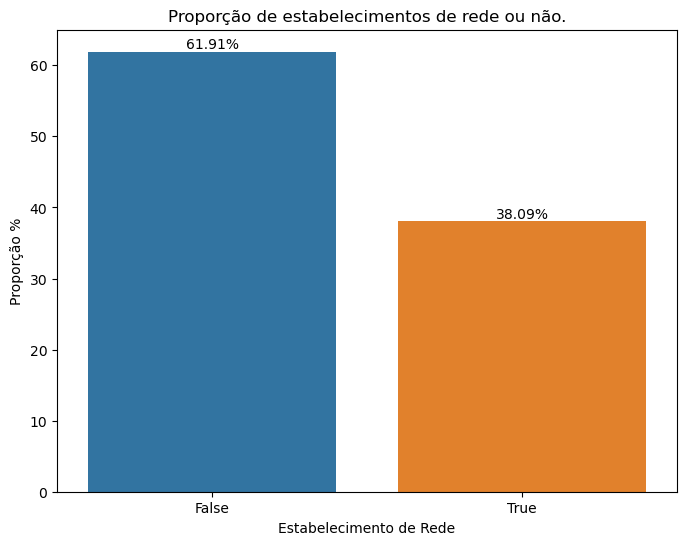

In [80]:
# Proporção do Total dos Estabelecimentos entre Rede ou não

plt.figure(figsize=(8,6))
chain_graph = sns.barplot(data=chain, x='chain', y='percent');

for g in chain_graph.patches:
    txt = np.round(g.get_height(), decimals=2)
    anot = txt.astype('str')
    chain_graph.annotate(anot+'%', (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), rotation=0, 
                   textcoords = 'offset points')
    
plt.title('Proporção de estabelecimentos de rede ou não.')
plt.xlabel('Estabelecimento de Rede')
plt.ylabel('Proporção %')
plt.show()

Podemos observar que a preferência de negócio sãos os negócios próprios nos dados colhidos. Talvez pelo preço da franquia das redes que costumam ser muito caras. 

Uma pesquisa rápida pela internet uma franquia do McDonald´s pode custar entre \$1,314,500 e  \$2,306,500. O que pode tentar explicar um pouco essa proporção.

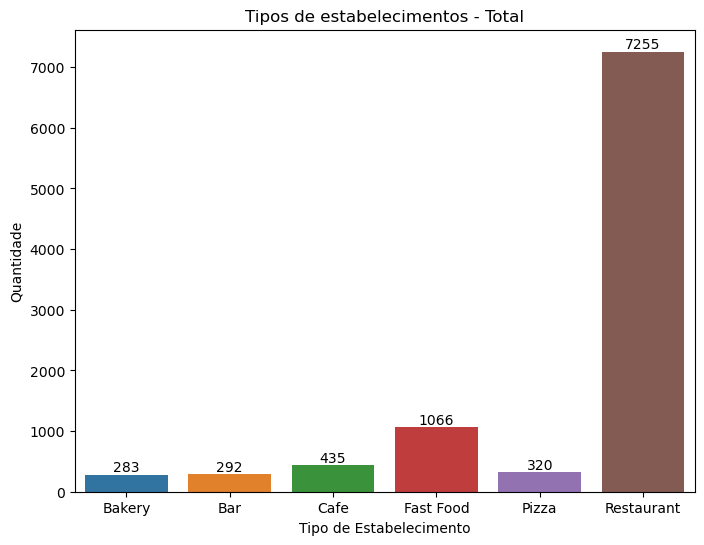

In [81]:
# Tipos de Estabelecimentos

plt.figure(figsize=(8 ,6))
type_o_graph = sns.barplot(data=type_o, x='object_type', y='id');

for g in type_o_graph.patches:
    type_o_graph.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), rotation=0, 
                   textcoords = 'offset points')
    
plt.title('Tipos de estabelecimentos - Total')
plt.xlabel('Tipo de Estabelecimento')
plt.ylabel('Quantidade')
plt.show()

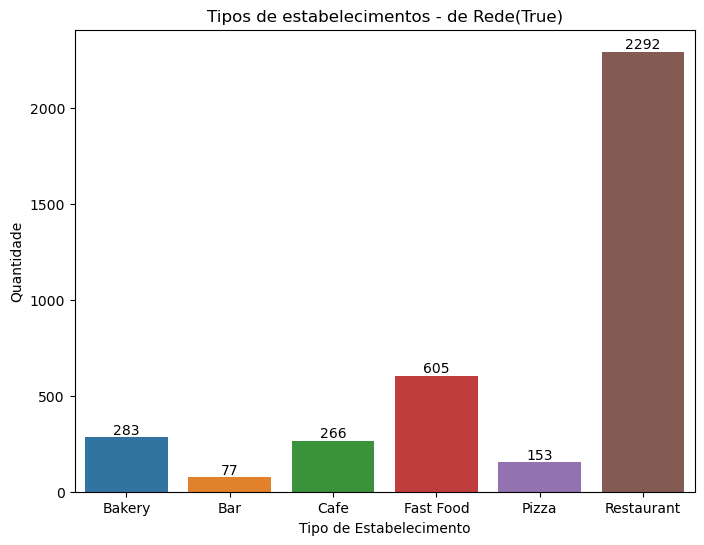

In [82]:
# Tipos de Estabelecimento de Rede

plt.figure(figsize=(8,6))
on_chain_per_type_graph = sns.barplot(data=chain_true, 
                                  x='object_type',
                                  y='id')

for g in on_chain_per_type_graph.patches:
    on_chain_per_type_graph.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), rotation=0, 
                   textcoords = 'offset points')
    
plt.title('Tipos de estabelecimentos - de Rede(True)')
plt.xlabel('Tipo de Estabelecimento')
plt.ylabel('Quantidade')
plt.show()

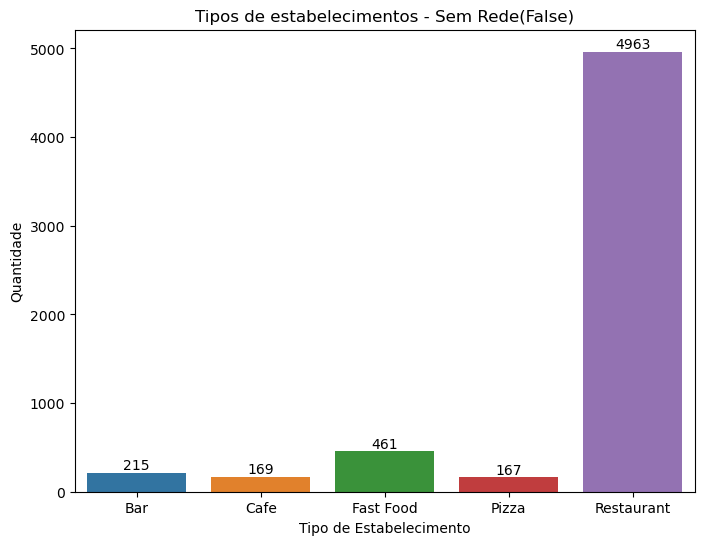

In [83]:
#Estabelecimentos sem rede

plt.figure(figsize=(8,6))
off_chain_per_type_graph = sns.barplot(data=chain_false, 
                                  x='object_type',
                                  y='id')

for g in off_chain_per_type_graph.patches:
    off_chain_per_type_graph.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), rotation=0, 
                   textcoords = 'offset points')
    
plt.title('Tipos de estabelecimentos - Sem Rede(False)')
plt.xlabel('Tipo de Estabelecimento')
plt.ylabel('Quantidade')
plt.show()

,object_type,chain,id
0,Bakery,True,283
1,Bar,False,215
2,Bar,True,77
3,Cafe,False,169
4,Cafe,True,266
5,Fast Food,False,461
6,Fast Food,True,605
7,Pizza,False,167
8,Pizza,True,153
9,Restaurant,False,4963


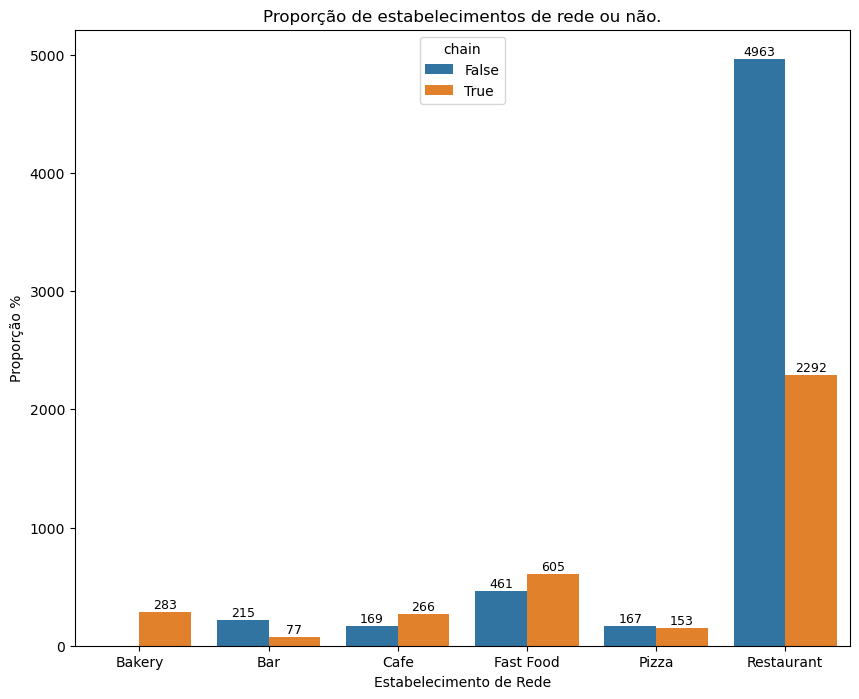

In [84]:
chain_pivot = df.pivot_table(index=['object_type', 'chain'], values='id', aggfunc='count').reset_index()
display(chain_pivot)
print('='*112)





plt.figure(figsize=(10, 8))
chain_pivot_graph = sns.barplot(data=chain_pivot.reset_index(), x='object_type', y='id', hue='chain');
plt.title('Quantidade de estabelecimentos')
plt.xlabel('Tipo de Estabelecimento')
plt.ylabel('Quantidade')



for g in chain_pivot_graph.patches:
    txt = np.round(g.get_height(), decimals=2)
    anot = txt.astype('str')
    chain_pivot_graph.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', fontsize=9, 
                   xytext = (0, 5), rotation=0, 
                   textcoords = 'offset points')
    
plt.title('Proporção de estabelecimentos de rede ou não.')
plt.xlabel('Estabelecimento de Rede')
plt.ylabel('Proporção %')
plt.show()



Aqui podemos observar que os estabelecimentos de rede são mais comuns as Padarias(bakery), Fast Foods, Cafés em relação aos restaurantes vemos que o número de restaurantes únicos são bem maiores, possivelmente pelo carater de qualidade do restaurante, que segue um padrão diferente dos outros tipos, como Fast Food, por exemplo. 

,object_name,id
1942,SUBWAY,152
1933,STARBUCKS,129
1335,MCDONALD'S,82
2071,THE COFFEE BEAN & TEA LEAF,55
585,EL POLLO LOCO,38
1007,KENTUCKY FRIED CHICKEN,31
486,DOMINO'S PIZZA,30
2146,TRIMANA,27
281,CARL'S JR,24
2251,YOGURTLAND,21


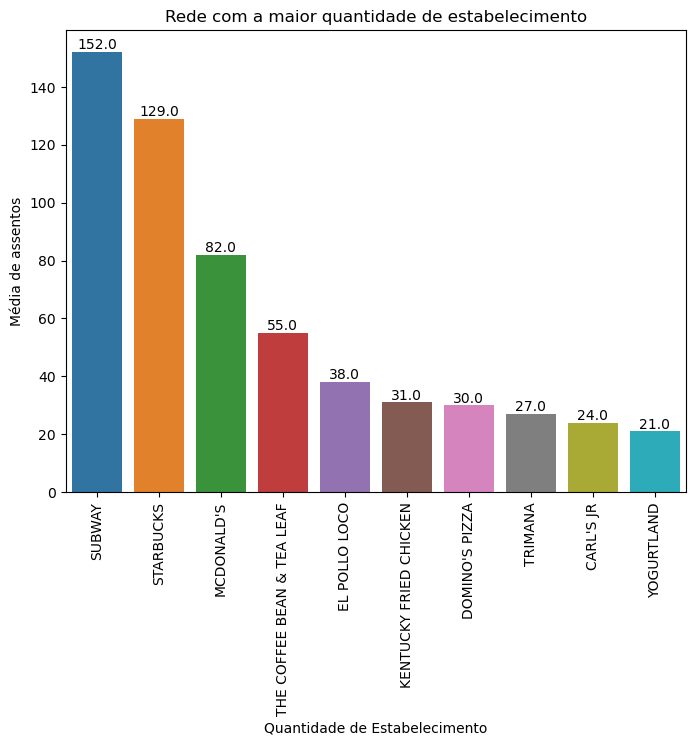

In [85]:
chains = df.query("chain == True").groupby('object_name')['id'].count().reset_index()
display(chains.query('id > 1').sort_values(ascending=False, by='id').head(10))
print('='*92)





plt.figure(figsize=(8,6))
chain_graph = sns.barplot(data=chains.nlargest(10, 'id'), 
                                  x='object_name',
                                  y='id')

for g in chain_graph.patches:
    chain_graph.annotate(format(g.get_height(), '.1f'), (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), rotation=0, 
                   textcoords = 'offset points')
    
plt.title('Rede com a maior quantidade de estabelecimento')
plt.xlabel('Quantidade de Estabelecimento')
plt.xticks(rotation=90)
plt.ylabel('Média de assentos')
plt.show()

In [86]:
chains = df.groupby('object_name').agg({'id':'count','number':'sum'}).sort_values(by='id', ascending=False)
chains.columns = ['unidades', 'assentos']



,unidades,assentos,mean
object_name,,,
MCDONALD'S,82,7682,93.68
STARBUCKS,129,3499,27.12
SUBWAY,152,2625,17.27
EL POLLO LOCO,38,2482,65.32
CARL'S JR,24,2228,92.83
THE COFFEE BEAN & TEA LEAF,55,1374,24.98
KENTUCKY FRIED CHICKEN,31,1237,39.90
TRIMANA,27,1073,39.74
CHIPOTLE MEXICAN GRILL,19,816,42.95


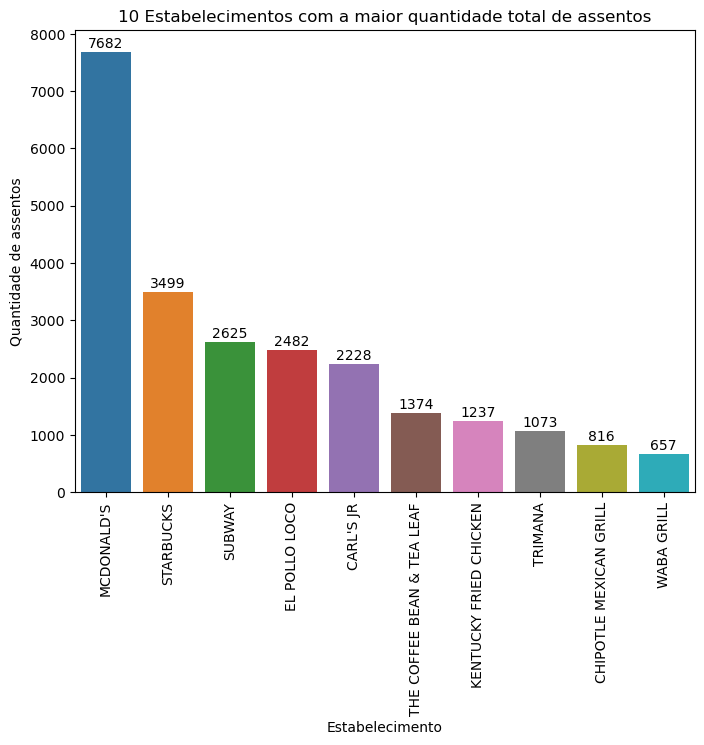

In [87]:
plt.figure(figsize=(8,6))
seats_ranking = sns.barplot(data=chains.sort_values(by='assentos', ascending= False).reset_index().head(10), x='object_name', y='assentos')
chains['mean'] = round(chains['assentos'] / chains['unidades'], 2)


display(chains.sort_values(by='assentos', ascending= False).head(10))
print('='*92)


for g in seats_ranking.patches:
    seats_ranking.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2, g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 6), rotation=0, 
                   textcoords = 'offset points')
    
plt.title('10 Estabelecimentos com a maior quantidade total de assentos')
plt.xlabel('Estabelecimento')
plt.ylabel('Quantidade de assentos')
plt.xticks(rotation=90)
plt.show()




,object_type,avg_number_of_seats
0,Restaurant,48
1,Bar,44
2,Fast Food,31
3,Pizza,28
4,Cafe,25
5,Bakery,21


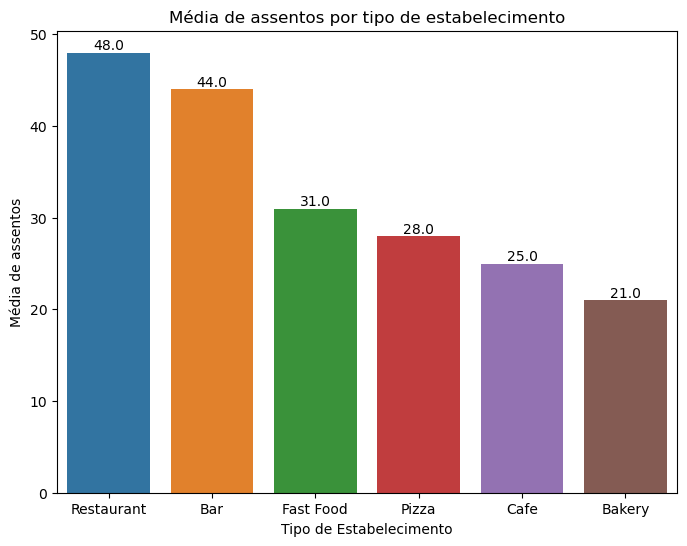

In [88]:


seat_per_type = (df.groupby('object_type').agg({'number':'mean'}).rename(columns={'number':'avg_number_of_seats'})).sort_values('avg_number_of_seats', ascending=False).reset_index()

seat_per_type['avg_number_of_seats'] = seat_per_type['avg_number_of_seats'].astype(int)

display(seat_per_type)
print('='*90)


plt.figure(figsize=(8,6))
seat_per_type_graph = sns.barplot(data=seat_per_type.nlargest(6, 'avg_number_of_seats'), 
                                  x='object_type',
                                  y='avg_number_of_seats')

for g in seat_per_type_graph.patches:
    seat_per_type_graph.annotate(format(g.get_height(), '.1f'), (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), rotation=0, 
                   textcoords = 'offset points')
    
plt.title('Média de assentos por tipo de estabelecimento')
plt.xlabel('Tipo de Estabelecimento')
plt.ylabel('Média de assentos')
plt.show()



Aqui notamos que os bares e restaurantes, pelo carater de negócio, possuem mais assentos em média que os outros estabelecimentos, como por exemplo:

* Cafés e Padarias: Que as pessoas passam para pegar algum lanchinho, bolo, ou um café e partem para seus destinos;
* Pizzaria e Fast Foods: São estabelicimentos, no caso do primeiro, focado em entregas, já o segundo como o nome já diz "comida rápida" são caracterizados pelos Drivre Thru.

In [89]:
df['street_name'] = df.address.apply(addr_parse)

,street_name,number_of_establishment,avg_number_of_seats
476,SUNSET BLVD,403,47
538,WILSHIRE BLVD,397,52
412,PICO BLVD,370,40
524,WESTERN AVE,367,41
212,FIGUEROA ST,332,44
394,OLYMPIC BLVD,309,49
503,VERMONT AVE,286,45
443,SANTA MONICA BLVD,264,35
28,3RD ST,261,40
262,HOLLYWOOD BLVD,253,57


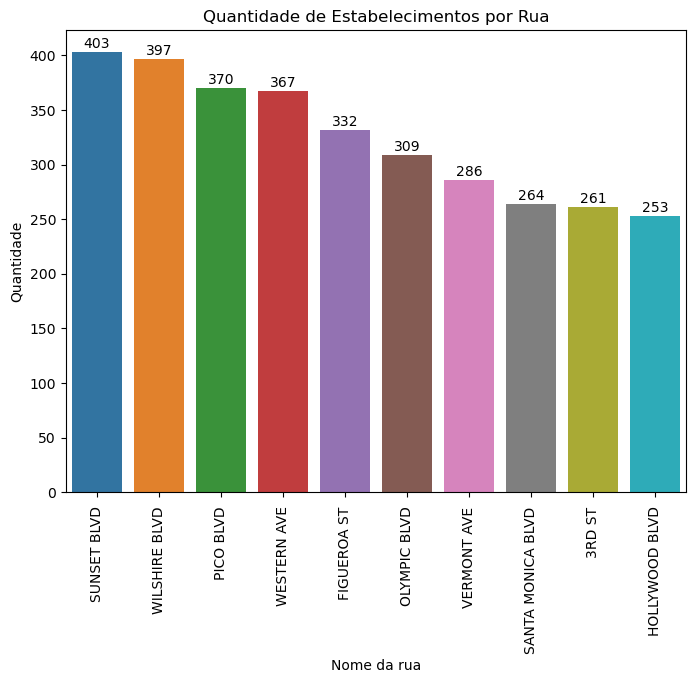

In [90]:
stre_addr = (df
           .groupby('street_name')
           .agg({'id':'count','number':'mean'})
           .rename(columns={'id':'number_of_establishment', 'number': 'avg_number_of_seats'})
           .reset_index()
           )
stre_addr['avg_number_of_seats'] = stre_addr.avg_number_of_seats.astype(int)


display(stre_addr.sort_values('number_of_establishment', ascending=False).head(10))
print('='*91)

plt.figure(figsize=(8,6))
establishment_per_street_graph = sns.barplot(data=stre_addr.nlargest(10,'number_of_establishment'), 
                                  x='street_name',
                                  y='number_of_establishment')

for g in establishment_per_street_graph.patches:
    establishment_per_street_graph.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 6), rotation=0, 
                   textcoords = 'offset points')
    
plt.title('Quantidade de Estabelecimentos por Rua')
plt.xlabel('Nome da rua')
plt.ylabel('Quantidade')
plt.xticks(rotation=90)
plt.show()

Podemos observar que a Sunset Boulevard é a que possui a maior quantidade de estabelecimentos alimentícios na região, seguida de perto pela Wilshire Boulevard.

,street,object_type
0,Restaurant,296
1,Fast Food,34
2,Cafe,28
3,Pizza,18
4,Bar,14
5,Bakery,13


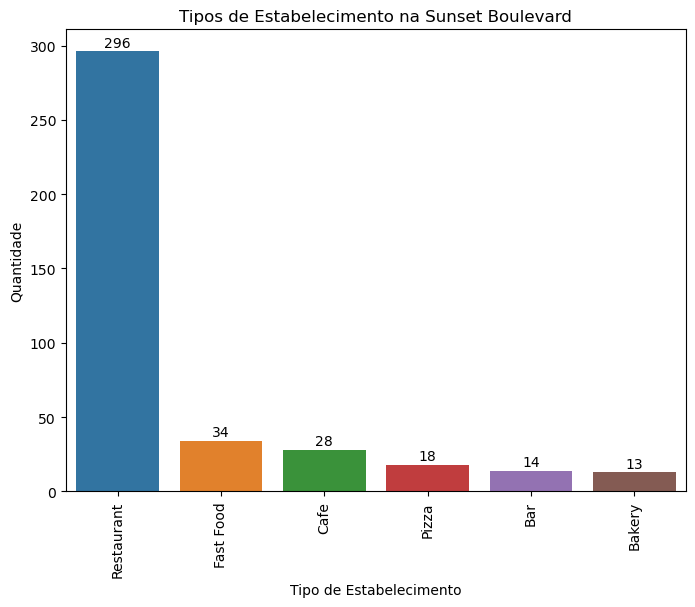

In [91]:
sunset_blvd = df[df['street_name'] == 'SUNSET BLVD ']['object_type'].value_counts().reset_index().rename(columns={'index': 'street'})

display(sunset_blvd)
print('='*92)

plt.figure(figsize=(8,6))
sunset_blvd_graph = sns.barplot(data=sunset_blvd,
                                  x='street',
                                  y='object_type')

for g in sunset_blvd_graph.patches:
    sunset_blvd_graph.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 6), rotation=0, 
                   textcoords = 'offset points')
    
plt.title('Tipos de Estabelecimento na Sunset Boulevard')
plt.xlabel('Tipo de Estabelecimento')
plt.ylabel('Quantidade')
plt.xticks(rotation=90)
plt.show()

De longe a maior quantidade de estabelecimentos alimentícios da Sunset são restaurantes. Isso pode mostrar que os outros estabelecimentos novos de outros modelo que não restaurantes podem não possuir tanta procura do público. A região, também, pode ser uma região mais noturna por isso a quantidade maior de restaurantes. 

In [92]:
cafe = df.groupby(['object_type', 'street_name'])['id'].count().reset_index()
cafe[cafe['object_type'] == 'Cafe'].sort_values('id', ascending=False).head(5)

,object_type,street_name,id
325,Cafe,WORLD WAY,28
307,Cafe,SUNSET BLVD,28
324,Cafe,WILSHIRE BLVD,25
260,Cafe,HOLLYWOOD BLVD,14
294,Cafe,PICO BLVD,13


In [93]:
filter_street_df = stre_addr[stre_addr['number_of_establishment'] == 1]
display(filter_street_df.head())
print('='*68)
print(f'Existem um total de {filter_street_df.shape[0]} ruas com apenas 1 estabelecimento')

,street_name,number_of_establishment,avg_number_of_seats
1,1/4 FAIR PARK AVE,1,40
2,103,1,5
4,10TH ST,1,18
6,11th ST,1,29
10,16TH ST,1,71


Existem um total de 250 ruas com apenas 1 estabelecimento


O número médio de assentos nas ruas que possuem mais de 1 estabelecimento é:47


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


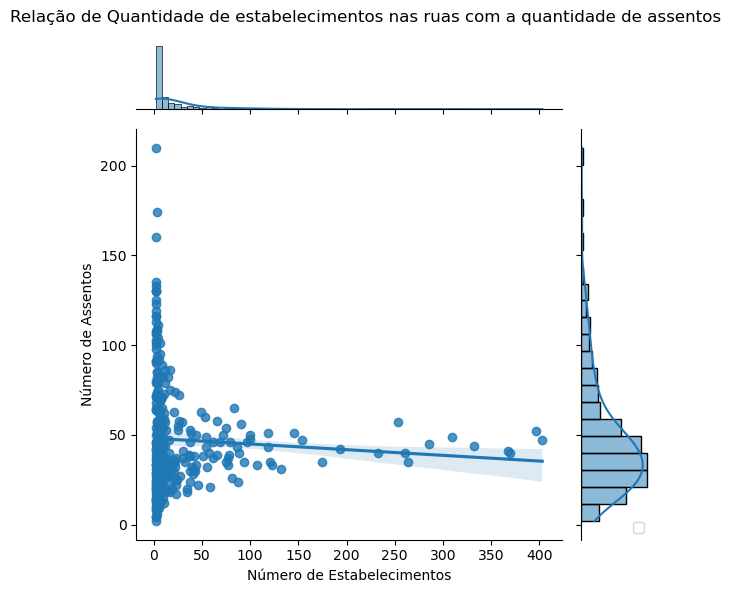

In [94]:
filter_street = stre_addr[stre_addr['number_of_establishment'] > 1].rename(columns={'number_of_establishment':'Número de Estabelecimentos', 'avg_number_of_seats':'Número de Assentos'})
media = stre_addr[stre_addr['number_of_establishment'] > 1]['avg_number_of_seats'].mean()

print(f'O número médio de assentos nas ruas que possuem mais de 1 estabelecimento é:{round(media)}')
print('='*100)



joint = sns.jointplot(data=filter_street, x='Número de Estabelecimentos', y='Número de Assentos', kind='reg');
joint.set_axis_labels('Número de Estabelecimentos', 'Número de Assentos')
joint.fig.suptitle('Relação de Quantidade de estabelecimentos nas ruas com a quantidade de assentos')
joint.fig.tight_layout()
plt.legend(loc='lower right')



plt.show();



Aqui podemos notar que a quantidade de assentos médios é entre 40 e 50 e que parece ser um padrão entre os estabelecimentos.

Mesmo sendo um estabelecimento de Rede, o McDonald's possui uma capacidade enorme de acomodação ao público. As 13 unidades contabilizadas possuem capacidade para 1259 pessoas o que é um número e tanto. Cerca 97 assentos por unidade.

In [95]:
df.groupby('object_type')['number'].mean().round()

object_type
Bakery        22.0
Bar           45.0
Cafe          25.0
Fast Food     32.0
Pizza         28.0
Restaurant    48.0
Name: number, dtype: float64

# Conclusão



Como o intuito é a criação de um Café com Robôs garçons, não deveriamos fugir do padrão médio de assentos para o estabelecimento que é de 25 lugares.
Como todo início de de ideia ou de um negócio tão original e "revolucionário" a demanda inicial pode ser muito grande, porém com o passar do tempo aquilo deixa de ser novidade e passa a se adequar a realidade.

>> Modelo

Posto isso não podemos gastar mais que o necessário devido ao "boom" inicial que pode trazer uma falsa impressão da demanda, pois todo negócio precisa de estabilidade de receita, momentos ou receita atípica não refletem o real propósito ou o real faturamento do empreendimento. Portanto, devemos nos adequar ao molde padrão em um primeiro momento para analisarmos com o passar do tempo as reais necessidades do empreendimento e sua eventual adaptação.

>> Local

A respeito do local, devemos observar dois pontos:

* A quantidade de empreendimentos totais das ruas:
> * Pois ruas com mais empreendimentos indica serem são mais movimentadas. 

* A quantidade de cafeterias nas ruas:
> * Pode ser um ponto conhecido do público onde se busca pelo produto ofertado. Ficando mais fácil a evidência do empreendimento. 



Finalizando a conslusão, a rua mais indicada para instalar o empreendimento é a Sunset Boulevard pois a ela abrange ambos os requerimentos de Local, que é uma rua movimentada com o maior número de empreendimentos e uma rua que possui um comércio do ramo de cafeterias consolidado que deixaria a nossa cafeteria em evidência. 